<a href="https://colab.research.google.com/github/jpasamar19/TallerVirtual/blob/main/Taller-DinamicaMolecular/MolecularDynamic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TALLER VIRTUAL INTERACTIVO: Descubriendo las principales áreas de la Bioinformática**
---


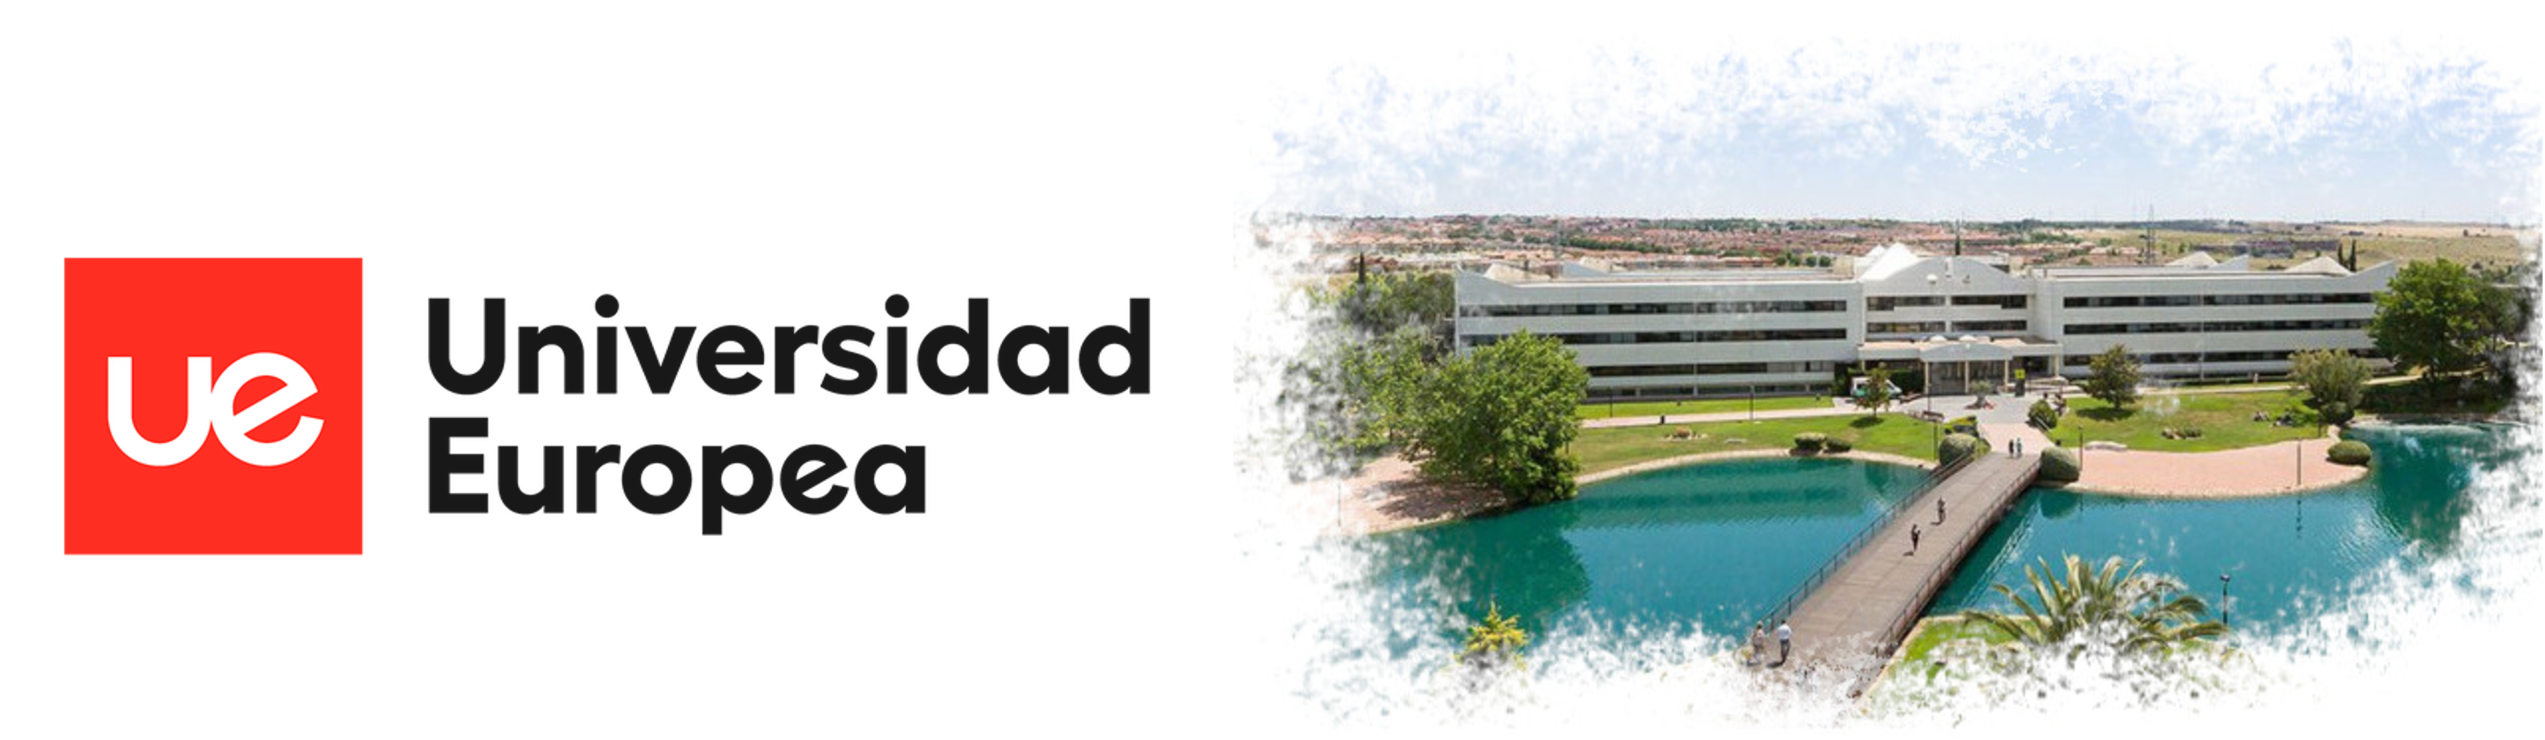

---

# **TALLER DE DINAMICA MOLECULAR**


<p align="Justify"> <b>La dinámica molecular (MD)</b> es una poderosa técnica computacional utilizada en el campo de la química y la física para <font color='blue'>estudiar el comportamiento de átomos y moléculas en movimiento</font>. Esta técnica simula el movimiento de las partículas en función de las fuerzas intermoleculares y las leyes de la física, como <b>la mecánica clásica y la mecánica cuántica</b>, en el caso de simulaciones más avanzadas.

<p align="Justify">En esencia, una simulación de dinámica molecular permite visualizar y comprender cómo las moléculas se mueven y cambian con el tiempo. Esto es fundamental para comprender una amplia gama de fenómenos, desde <u>la estructura y la función de proteínas en biología hasta las propiedades de materiales en la nanotecnología</u>.

<p align="Justify">Para llevar a cabo una simulación de dinámica molecular, se requiere un modelo molecular detallado del sistema de interés, así como algoritmos computacionales eficientes que calculen las fuerzas entre las partículas y resuelvan las ecuaciones de movimiento. Estas simulaciones pueden realizarse en una variedad de condiciones, como diferentes temperaturas, presiones o concentraciones de solutos, lo que permite explorar cómo estas variables afectan el comportamiento del sistema.

In [ ]:
#@markdown Cargar los archivos de entrada.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

new_var = "/content/RESULTADOS/"

if os.path.exists(new_var):
  print("Archivos importados correctamente")
else:
  !git clone https://github.com/jpasamar19/TallerVirtual.git &> /dev/null
  !mv /content/TallerVirtual/Taller-DinamicaMolecular/INPUT/* .
  !mv /content/TallerVirtual/Taller-DinamicaMolecular/RESULTADOS/ .
  !rm -r /content/TallerVirtual


In [ ]:
#@markdown Mostrar un ejemplo de MD.

gifPath = "/content/unnamed.gif" # please paste the whole path from Step 2-6

with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')

print('Acosta J, Pérez E, Sánchez-Murcia PA, Fillat C, Fernández-Lucas J.')
print('Molecular Basis of NDT-Mediated Activation of Nucleoside-Based Prodrugs and Application in Suicide Gene Therapy.')
print('Biomolecules. 2021 Jan 18;11(1):120. doi: 10.3390/biom11010120. PMID: 33477716; PMCID: PMC7831932.')

---
---
## **1. INSTALACIÓN DE PROGRAMAS**

In [ ]:
#@title **1.1 Comprueba si has asignado correctamente los nodos GPU**

#@markdown Una **GPU (Unidad de Procesamiento Gráfico)** es un componente de hardware que,
#@markdown además de renderizar gráficos,
#@markdown puede acelerar cálculos computacionales intensivos,
#@markdown como las simulaciones de dinámica molecular,
#@markdown gracias a su arquitectura paralela y capacidad de procesamiento masivo.


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Selecciona "Entorno de ejecución" > "Cambiar tipo de entorno de ejecución" > "Acelerador por hardware" > "T4 GPU" , ')
  print('y luego volver a ejecutar esta celda.')
else:
  print(gpu_info)

#@markdown ---

In [ ]:
#@title **1.2 Instalar Conda Colab**
#@markdown Este proceso tarda entorno a 1 minuto. **Reiniciará** el kernel (sesión).
!pip install -q condacolab
import condacolab
condacolab.install()

#@markdown ---

In [ ]:
#@title **1.3 Instalar dependencias**
#@markdown Este proceso tarda entorno a **2 minutos.**
# install dependencies
import sys
import time
import contextlib

start = time.time()

import subprocess
import sys
subprocess.run("rm -rf /usr/local/conda-meta/pinned", shell=True)
subprocess.run("mamba install -c conda-forge ambertools -y", shell=True)
import pytraj as pt
subprocess.run("pip -q install py3Dmol", shell=True)
subprocess.run("pip install git+https://github.com/pablo-arantes/biopandas", shell=True)
subprocess.run("mamba install openmm=7.7.0 pdbfixer -y", shell=True)
subprocess.run("mamba install openmmforcefields -c conda-forge -y", shell=True)
subprocess.run("pip install prolif==1.1.0", shell=True)
subprocess.run("mamba install -c conda-forge openbabel -y", shell=True)
subprocess.run("mamba install -c conda-forge parmed -y", shell=True)
subprocess.run("pip install --upgrade MDAnalysis==2.4.2", shell=True)

#load dependencies
from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
import parmed as pmd
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request
import numpy as np
import MDAnalysis as mda
import py3Dmol
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats

end = time.time()

print(f'+ Tiempo transcurrido para la instalación: ' + time.strftime('%Mm %Ss', time.gmtime(end - start)))

#@markdown ---


In [ ]:
# @title **1.4 Importar módulos de Python**
# @markdown Este proceso importará los módulos de Python necesarios.

# LaboSpace Viewer

class LaboSpace:

    residue_style = {
        'stick':
         {'colorscheme': 'orangeCarbon', 'radius': 0.15}}
    residue_label = {
        'alignment': 'bottomLeft',
        'showBackground': False,
        'inFront': True,
        'fontSize': 14,
        'fontColor': '0x000000',
        'screenOffset': {'x': 25, 'y': 25}}
    atom_label = {
        'alignment': 'bottomLeft',
        'showBackground': False,
        'inFront': True,
        'fontSize': 14,
        'fontColor': '0x000000',
        'screenOffset': {'x': 10, 'y': 10}}

    def __init__(self, vw: int = 500, vh: int = 500) -> None:
        self.mview = py3Dmol.view(width=vw, height=vh)
        self.count = -1
        self.residues = []

    def read_moldata(self, inpt_file: str) -> str:
        inpt = open(inpt_file, 'r')
        data = inpt.read()
        inpt.close()
        return data

    def load_receptor(self, inpt_file: str) -> object:
        data = self.read_moldata(inpt_file)
        self.mview.addModel(data, 'pdb')
        self.count += 1
        return self

    def load_ligand(self, inpt_file: str) -> object:
        data = self.read_moldata(inpt_file)
        self.mview.addModel(data)
        self.count += 1
        return self

    def set_style(self,
                  show_represent: bool = True,
                  represent_type: str = 'cartoon',
                  represent_style: dict = {}
                  ) -> object:
        if show_represent:
            self.mview.setStyle(
                {'model': self.count},
                {represent_type: represent_style})
        else:
            self.mview.setStyle(
                {'model': self.count},
                {})
        return self

    def add_style(self,
                  show_represent: bool = True,
                  represent_style: dict = {}
                  ) -> object:
        if show_represent:
            self.mview.addStyle(
                {'model': self.count},
                represent_style)
        return self

    def add_residues(self,
                     show_residues: bool = True,
                     residue_number: str = ''
                     ) -> object:
        if show_residues and residue_number:
            res = residue_number.replace(',', ' ').split()
            self.residues.extend(list(set(res)))
            self.mview.addStyle(
                {'and': [{'model': self.count}, {'resi': self.residues}]},
                self.residue_style)
            self.mview.addResLabels(
                {'and': [{'model': self.count}, {'resi': self.residues}]},
                self.residue_label)
        return self

    def add_surface(self,
                    show_surface: bool = True,
                    surface_type: str = 'SES',
                    surface_style: dict = {}
                    ) -> object:
        if show_surface:
            self.mview.addSurface(
                surface_type,
                surface_style,
                {'model': self.count})
        return self

    def add_gridbox(self,
                    show_gridbox: bool,
                    center: list[float],
                    bxsize: list[float]
                    ) -> object:
        if show_gridbox:
            bxi, byi, bzi = center
            bxf, byf, bzf = bxsize
            self.mview.addBox({
                'center': {'x': bxi, 'y': byi, 'z': bzi},
                'dimensions': {'w': bxf, 'h': byf, 'd': bzf},
                'color': 'skyBlue',
                'opacity': 0.6})
            self.mview.addLabel(
                f'center: {bxi:>8}, {byi:>8}, {bzi:>8}',
                {'showBackground': False,
                 'fontSize': 14,
                 'fontColor': '0x000000',
                 'useScreen': True,
                 'screenOffset': {'x': 15, 'y': 0}})
            self.mview.addLabel(
                f'bxsize: {bxf:>8}, {byf:>8}, {bzf:>8}',
                {'showBackground': False,
                 'fontSize': 14,
                 'fontColor': '0x000000',
                 'useScreen': True,
                 'screenOffset': {'x': 15, 'y': -20}})
        return self

    def add_interaction(self,
                        interaction_file: str,
                        show_interaction: bool = True,
                        select_interaction: list = []
                        ) -> object:
        if show_interaction:
            int_dict = interaction_dict(interaction_file, select_interaction, 'lbsp')
            dist = int_dict['DIST'].values()
            bond = int_dict['BOND'].values()
            resn = int_dict['RESNR'].values()
            ligcoo = int_dict['LIGCOO'].values()
            prtcoo = int_dict['PROTCOO'].values()
            color = int_dict['COLOR'].values()

            int_res = list(set(resn) - set(self.residues))
            self.residues.extend(int_res)
            self.mview.addStyle(
                {'and': [{'model': 0}, {'resi': int_res}]},
                self.residue_style)
            self.mview.addResLabels(
                {'and': [{'model': 0}, {'resi': int_res}]},
                self.residue_label)

            for dis, col, lig, prt in zip(dist, color, ligcoo, prtcoo):
                mid = find_midpoint([lig, prt])
                self.mview.addCylinder(
                    {'start': {'x': lig[0], 'y': lig[1], 'z': lig[2]},
                     'end': {'x': prt[0], 'y': prt[1], 'z': prt[2]},
                     'radius': 0.05,
                     'fromCap': 1,
                     'toCap': 1,
                     'color': col,
                     'dashed': True})
                self.mview.addLabel(
                    str(dis) + ' Å',
                    {'position': {'x': mid[0], 'y': mid[1], 'z': mid[2]},
                     'alignment': 'bottomLeft',
                     'inFront': False,
                     'backgroundColor': col,
                     'fontSize': 10,
                     'screenOffset': {'x': 10, 'y': 10}})
        return self

    def label_atoms(self, show_label: bool = False) -> object:
        # WARNING: Avoid applying on protein !!!
        if show_label:
            self.mview.addPropertyLabels(
                'atom',
                {'model': self.count},
                self.atom_label)
        return self

    def view_space(self,
                   zoom_model: int = -1,
                   slab_view: bool = False,
                   slab_model: int = -1,
                   background_colour: str = '0xFFFFFF'
                   ) -> None:
        self.mview.setBackgroundColor(background_colour)
        self.mview.setProjection('orthographic')
        self.mview.zoomTo({'model': zoom_model})
        self.mview.fitSlab({'model': slab_model}) if slab_view else None
        self.mview.show()

# Built-in Styling Function

def builtin_style(style: str, opacity: float = 1.0) -> dict:
    match style:
        case _ if any(kw in style for kw in ('Carbon', 'chain', 'ssJmol', 'ssPyMol')):
            style_dict = {'colorscheme': style}
        case 'hydrophobicity':
            style_dict = {'colorscheme': {
                'prop': 'resn', 'map': a2c_converter(AA_HB, sequential_gradient)}}
        case 'isoelectric points':
            style_dict = {'colorscheme': {
                'prop': 'resn', 'map': a2c_converter(AA_PI, diverging_gradient)}}
        case 'b factor':
            style_dict = {'colorscheme': {
                'prop': 'b', 'gradient': 'rwb', 'min': 90, 'max': 50}}
        case _:
            style_dict = {'color': style}

    style_dict.update({'opacity': opacity, 'singleBonds': False})
    return style_dict

#############################################
# Built-in Colour Scale Function

def colour_scale(aa_map: dict, grad_func: 'function') -> None:
    min_value = min(aa_map.values())
    max_value = max(aa_map.values())

    linear_values = np.linspace(min_value, max_value, 100)
    colours = [grad_func(value, min_value, max_value)
               for value in linear_values]

    fig, ax = plt.subplots(figsize=(4.85, 0.25))
    norm_value = plt.Normalize(min_value, max_value)
    colour_map = plt.cm.colors.ListedColormap(colours)
    scalar_map = plt.cm.ScalarMappable(norm_value, colour_map)
    scalar_map.set_array([])

    cscale = plt.colorbar(scalar_map, ax, orientation='horizontal')
    cscale.set_ticks([min_value, max_value])

def show_cscale(rept_info: dict, surf_info: dict) -> None:

    def cs_selector() -> str:
        if any(surf_info):
            style = [*surf_info.values()][0]
        elif any(rept_info):
            style = [*rept_info.values()][0]
        else:
            style = None
        return style

    def cs_display(style: str):
        if style == 'hydrophobicity':
            label_title(style, 'Less', 'More')
            colour_scale(AA_HB, sequential_gradient)
        elif style == 'isoelectric points':
            label_title(style, 'Acid', 'Base')
            colour_scale(AA_PI, diverging_gradient)
        else:
            pass

    def label_title(text: str, min: str, max: str) -> None:
        print(f'-' * 55)
        print(f'{min}{text.upper():^47}{max}')
        print(f'-' * 55)

    cs_display(cs_selector())


---
---
## **2. Preparación del sistema de simulación**

In [ ]:
# @title **2.1 Visualización de la estructura en 3D del flurbiprofeno**
# @markdown A continaución se visualizarán las estructuras en 3D de los medicamentos que se van a probar.

LIG_FLD='/conent'
Medicamento='FLB' # @ param ['FLB', 'Ibuprofeno', 'Aspirina', 'Fluorbiprofeno', 'Naproxeno','Diclofenaco']
View=Medicamento
Tipo_de_representacion='stick' # @param ['line', 'sphere', 'stick']
Representation_type=Tipo_de_representacion
Mostrar_etiqueta_atomos = True # @param {type: 'boolean'}
Show_atom_labels=Mostrar_etiqueta_atomos

LIG_view_lFile = os.path.join(LIG_FLD, View + '.sdf')

LBSP = LaboSpace(960, 640)
LBSP.load_ligand('/content/FLB.sdf')\
    .set_style(
        show_represent=True,
        represent_type=Representation_type,
        represent_style={'colorScheme': 'lightGreyCarbon'})\
    .label_atoms(
        show_label=Show_atom_labels)
LBSP.view_space()

#@markdown ---

In [ ]:
#@title **2.2 Introduce la carga de la molécula**
#@markdown **Importante:** La carga de tu ligando es crucial para la correcta parametrización de la molécula.
# %%capture
import rdkit
import mdtraj as md
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdForceFieldHelpers
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from pdbfixer import PDBFixer
from openbabel import pybel
import os
import subprocess
import warnings

# Suppress UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)


Protein_PDB_file_name = '4PH9.pdb' #@ param {type:"string"}
remove_waters = "yes" #@ param ["yes", "no" ]
if remove_waters == "yes":
  no_waters = "nowat"
else:
  no_waters = ''

Ligand_PDB_file_name = 'FLB.pdb'  #@ param {type:"string"}

Add_ligand_hydrogens = "No" #@ param ["Yes", "No"]
Carga = -1 #@param {type:"slider", min:-10, max:10, step:1}
Charge = Carga


ligand_name = Ligand_PDB_file_name
Google_Drive_Path = '/content/' #@ param {type:"string"}
workDir = Google_Drive_Path
initial_pdb = os.path.join(workDir, str(Protein_PDB_file_name))
prepareforleap = os.path.join(workDir, "prepareforleap.in")
ligand_pdb = os.path.join(workDir, str(ligand_name))
ligand_pdb2 = os.path.join(workDir, "ligand_H.pdb")
starting = os.path.join(workDir, "starting1.pdb")
starting2 = os.path.join(workDir, "starting2.pdb")
starting_end = os.path.join(workDir, "starting_end.pdb")


def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

def remove_lines(filename):
    with open(filename, 'r') as file:
        ter_count = 0
        for line in file:
            if line.startswith('TER'):
                ter_count += 1
                if ter_count >= 1:
                    yield line
                    for i in range(3):
                        line = next(file, None)
                        if line is not None and line.startswith('ATOM') and line.split()[2] in ['P', 'OP1', 'OP2']:
                            continue
                        else:
                            yield line
                else:
                    yield line
            else:
                yield line

# if Add_ligand_hydrogens == "Yes":
#   mol= [m for m in pybel.readfile(filename=ligand_pdb, format='pdb')][0]
#   out=pybel.Outputfile(filename="temp.mol",format='mol',overwrite=True)
#   out.write(mol)
#   out.close()

#   mol = Chem.MolFromMolFile('temp.mol', removeHs=True)
#   hmol = Chem.AddHs(mol)
#   mp = AllChem.MMFFGetMoleculeProperties(hmol)
#   ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
#   for a in hmol.GetAtoms():
#     if (a.GetAtomicNum() > 1):
#       ff.MMFFAddPositionConstraint(a.GetIdx(), 0, 1.e4)
#   ff.Minimize(maxIts=1000)
#   charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
#   charge = Chem.GetFormalCharge(hmol)
#   print("Charge = " + str(charge))
#   # AllChem.MolToMolFile(hmol, (os.path.join(workDir, f"start_min.mol")))
#   AllChem.MolToPDBFile(hmol, ligand_pdb2)
#   mol_end = mol_with_atom_index(hmol)
#   IPythonConsole.drawMol3D(hmol)
# else:
#   mol= [m for m in pybel.readfile(filename=ligand_pdb, format='pdb')][0]
#   out=pybel.Outputfile(filename="temp.mol",format='mol',overwrite=True)
#   out.write(mol)
#   out.close()

#   hmol = Chem.MolFromMolFile('temp.mol', removeHs=False)
#   mp = AllChem.MMFFGetMoleculeProperties(hmol)
#   ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
#   for a in hmol.GetAtoms():
#     if (a.GetAtomicNum() > 1):
#       ff.MMFFAddPositionConstraint(a.GetIdx(), 0, 1.e4)
#   ff.Minimize(maxIts=1000)
#   charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
#   charge = Chem.GetFormalCharge(hmol)
#   print("Charge = " + str(charge))
#   # AllChem.MolToMolFile(hmol, (os.path.join(workDir, f"start_min.mol")))
#   AllChem.MolToPDBFile(hmol, ligand_pdb2)
#   mol_end = mol_with_atom_index(hmol)
#   IPythonConsole.drawMol3D(hmol)



#Add hydrogens in the ligand
if Add_ligand_hydrogens == "Yes":
  fixer = PDBFixer(filename=ligand_pdb)
  PDBFile.writeFile(fixer.topology, fixer.positions, open("temp.pdb", 'w'))

  ppdb = PandasPdb().read_pdb("temp.pdb")
  ppdb.df['ATOM'] = ppdb.df['ATOM']
  ppdb.df['HETATM']= ppdb.df['HETATM'][ppdb.df['HETATM']['element_symbol'] != 'H']
  ppdb.to_pdb(path="temp.pdb", records=['ATOM', 'HETATM'], gz=False, append_newline=True)

  mol= [m for m in pybel.readfile(filename="temp.pdb", format='pdb')][0]
  mol.calccharges
  mol.addh()
  out=pybel.Outputfile(filename="temp2.pdb",format='pdb',overwrite=True)
  out.write(mol)
  out.close()

  md.load("temp2.pdb").save("temp2.pdb")

  halogens = ['Cl', 'F', 'Br', 'I']
  atom_id = []
  H_id = []
  with open("temp2.pdb") as f:
      for line in f:
        data = line.split()
        if data[0] == "ATOM":
          if data[2] in halogens:
            atom_id.append(data[1])
        if data[0] == "CONECT":
          if data[1] in atom_id:
            if len(data) > 3:
              H_id.append(data[3])
              H_id.append(data[4])
              H_id.append(data[5])

  # with open(ligand_pdb2, 'w') as h:
  #   with open("temp2.pdb") as f:
  #     for line in f:
  #       data = line.split()
  #       if data[0] == "ATOM":
  #         if data[1] not in H_id:
  #           print(line, file=h)
  #       elif data[0] == "CONECT":
  #           if data[1] not in atom_id:
  #             print(line, file=h)
  #       else:
  #         print(line, file=h)

  with open(ligand_pdb2, 'w') as h:
    with open("temp2.pdb") as f:
        for line in f:
            if line.strip():  # Check if line is not empty or just whitespace
                data = line.split()
                if len(data) > 0 and data[0] not in ["TER", "ENDMDL"]:  # Exclude lines starting with TER or ENDMDL
                    if data[0] == "ATOM":
                        if data[1] not in H_id:
                            print(line, end='', file=h)  # Avoid adding extra newline
                    elif data[0] == "CONECT":
                        if data[1] not in atom_id:
                            print(line, end='', file=h)
                    else:
                        print(line, end='', file=h)

  mol= [m for m in pybel.readfile(filename=ligand_pdb2, format='pdb')][0]
  out=pybel.Outputfile(filename="temp.mol",format='mol',overwrite=True)
  out.write(mol)
  out.close()
  hmol = Chem.MolFromMolFile('temp.mol', removeHs=False)
  # charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Charge
  print("Charge = " + str(charge))
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)

else:
  ppdb = PandasPdb().read_pdb(ligand_pdb)
  ppdb.df['ATOM'] = ppdb.df['ATOM']
  ppdb.to_pdb(path="temp.pdb", records=['ATOM', 'HETATM'], gz=False, append_newline=True)
  mol= [m for m in pybel.readfile(filename="temp.pdb", format='pdb')][0]
  mol.calccharges
  out=pybel.Outputfile(filename="temp2.pdb",format='pdb',overwrite=True)
  out.write(mol)
  out.close()

  md.load("temp2.pdb").save("temp2.pdb")

  with open(ligand_pdb2, 'w') as h:
    with open("temp2.pdb") as f:
        for line in f:
            if line.strip() and not line.startswith(("TER", "ENDMDL")):
                print(line, end='', file=h)

  mol= [m for m in pybel.readfile(filename=ligand_pdb2, format='pdb')][0]
  out=pybel.Outputfile(filename="temp.mol",format='mol',overwrite=True)
  out.write(mol)
  out.close()
  hmol = Chem.MolFromMolFile('temp.mol', removeHs=False)
  # charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Charge
  print("Charge = " + str(charge))
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)


#Fix protein
f = open(prepareforleap, "w")
f.write("""parm """ + str(initial_pdb) + "\n"
"""loadcrd """ + str(initial_pdb) + """ name edited""" + "\n"
"""prepareforleap crdset edited name from-prepareforleap \ """ + "\n"
"""pdbout """ + str(starting) + " " + str(no_waters) + """ noh""" + "\n"
"""go """)
f.close()

prepareforleap_command = "cpptraj -i " + str(prepareforleap)
original_stdout = sys.stdout # Save a reference to the original standard output
with open('prepareforleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(prepareforleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

subprocess.run(["chmod 700 prepareforleap.sh"], shell=True)
subprocess.run(["./prepareforleap.sh"], shell=True,)


pdb4amber_cmd = "pdb4amber -i " + str(starting) + " -o " + str(starting_end) + " -a"
original_stdout = sys.stdout # Save a reference to the original standard output

with open('pdb4amber.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(pdb4amber_cmd)
    sys.stdout = original_stdout # Reset the standard output to its original value

subprocess.run(["chmod 700 pdb4amber.sh"], shell=True)
subprocess.run(["./pdb4amber.sh"], shell=True,)

# with open(starting_end, 'w') as out_file:
#     for line in remove_lines(starting2):
#         out_file.write(line)

protein_check = os.path.exists(starting_end)
ligand_check = os.path.exists(ligand_pdb2)

if protein_check == True and ligand_check == True:
  print("Archivos de proteínas y ligandos generados con éxito! :-)")
else:
  print("ERROR: Comprueba tus archivos de entrada! ")

#@markdown ---

In [ ]:
from rdkit import Chem
from openff.toolkit.typing.engines.smirnoff import ForceField
import parmed

#@title **2.3 Parámetros para generar el sistema**


Force_field = "ff14SB" #@ param ["ff19SB", "ff14SB"]
if Force_field == "ff19SB":
  ff = "leaprc.protein.ff19SB"
else:
  ff = "leaprc.protein.ff14SB"

Water_type = "TIP3P" #@ param ["TIP3P", "OPC"]
if Water_type == "TIP3P":
  water = "leaprc.water.tip3p"
  water_box = "TIP3PBOX"
else:
  water = "leaprc.water.opc"
  water_box = "OPCBOX"

#@markdown Tamaño de la caja (Angstrons):

Dimension_caja = 9 #@param {type:"slider", min:9, max:20, step:1}
size_box = Dimension_caja

#@markdown **ATENCIÓN**: Indica el tipo de sal y la concentración (molar) que deseas usar, el programa neutralizará tu sistema automáticamente:

Sal = "NaCl" #@param ["NaCl", "KCl" ]
Ions = Sal

Concentracion = "0.15" #@param {type:"string"}
Concentration = Concentracion

#@ markdown **Parameters to generate the ligand topology:**

Ligand_Force_field = "GAFF2" #@ param ["GAFF2"]

# Ligand_isomer = "1" #@param {type:"string", min:1, max:10, step:100}
# if chiralCentres == []:
#   isomer_end = isomer1
# else:
#   isomer_end = globals()[f"isomer{Ligand_isomer}"]

Ligand_net_charges = charge

#@markdown ---
tleap = os.path.join(workDir, "tleap.in")
top_nw = os.path.join(workDir, "SYS_nw.prmtop")
crd_nw = os.path.join(workDir, "SYS_nw.crd")
pdb_nw = os.path.join(workDir, "SYS_nw.pdb")
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")
ligand_noh = os.path.join(workDir, "ligand_noh.pdb")
ligand_h = os.path.join(workDir, "ligand_h.pdb")
ligand_mol2 = os.path.join(workDir, "ligand.mol2")
ligand_frcmod = os.path.join(workDir, "ligand.frcmod")
lig_new = os.path.join(workDir, "ligand_gaff.pdb")
protein_ligand = os.path.join(workDir, "protein_ligand.pdb")
lib = os.path.join(workDir, "lig.lib")

#gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command3 = "antechamber -i " + str(ligand_h) + " -fi pdb -o " + str(ligand_mol2) + " -fo mol2 -c bcc -nc " + str(Ligand_net_charges) + " -rn LIG -at gaff2"
gaff_command4 = "parmchk2 -i " + str(ligand_mol2) + " -f mol2 -o " + str(ligand_frcmod) + " -s gaff2"

original_stdout = sys.stdout # Save a reference to the original standard output

with open('gaff.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(gaff_command1)
    print(gaff_command3)
    print(gaff_command4)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 gaff.sh 2>&1 1>/dev/null
!bash gaff.sh >/dev/null 2>&1

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.gaff2
LIG = loadmol2 """ + str(ligand_mol2) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""saveoff LIG """ + str(lib) + "\n"
"""savepdb LIG """ + str(lig_new) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)
cat_command = "cat " + str(starting_end) + " " + str(lig_new) + str(" > ") + str(protein_ligand)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    print(cat_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

ppdb = PandasPdb().read_pdb(protein_ligand)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['OTHERS'] = [ppdb.df['OTHERS'] != 'OTHERS']
ppdb.to_pdb(path=protein_ligand, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n"
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7
saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

SYS = os.path.join(workDir, "SYS*")
rm_sys = "rm " + SYS

original_stdout = sys.stdout # Save a reference to the original standard output

with open('rm_sys.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(rm_sys)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 rm_sys.sh 2>&1 1>/dev/null
!bash rm_sys.sh 2> /dev/null

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null


!grep "Volume:" leap.log > temp.txt
with open("temp.txt", 'r') as f:
  for line in f:
        vol = float(line.split()[1])

vol_lit  = vol * pow(10, -27)
atom_lit = 9.03 * pow(10, 22)
conc = float(Concentration)
num_ion = int(vol_lit * (conc/0.15) * atom_lit)

if Ions == "NaCl":
  pos_neut = "Na+ 0"
  pos_num = "Na+ " + str(num_ion)
  Cl_num = num_ion
else:
  pos_neut = "K+ 0"
  pos_num = "K+ " + str(num_ion)
  Cl_num = num_ion

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n"
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
check SYS
charge SYS
addions SYS """ + str(pos_neut) + "\n"
"""addions SYS Cl- 0
check SYS
charge SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7 """ + "\n"
"""addIonsRand SYS """ + str(pos_num) + """ Cl- """ + str(Cl_num) + "\n"
"""saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()


!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

pdb_amber = os.path.exists(pdb)
top_amber = os.path.exists(top)
crd_amber = os.path.exists(crd)

if pdb_amber == True and top_amber == True and crd_amber == True:
  print("Successfully generated topology! :-)")
else:
  print("ERROR: Check your inputs! ")
!rm *.sh  ANTECHAMBER* ATOMTYPE* temp.txt >/dev/null 2>&1

In [ ]:
#@title **2.4 Mostrar el sistema de simulación**
import warnings
warnings.filterwarnings('ignore')
import py3Dmol

color = "gray" #@ param ["gray", "rainbow"]
Mostrar_cadena_lateral = False #@param {type:"boolean"}
show_sidechains = Mostrar_cadena_lateral
Mostrar_cadena_principal = False #@param {type:"boolean"}
show_mainchains = Mostrar_cadena_principal
Mostrar_ligando = True #@param {type:"boolean"}
show_ligand = Mostrar_ligando
Mostrar_caja = True #@param {type:"boolean"}
show_box = Mostrar_caja
Transparencia_caja = 0.6 #@param {type:"slider", min:0, max:1, step:0.1}
box_opacity = Transparencia_caja


def show_pdb(show_sidechains=False, show_mainchains=False, show_ligand = False, show_box = False, color="rainbow"):
  view = py3Dmol.view(width=800, height=600)
  view.addModel(open(pdb,'r').read(),'pdb')

  if color == "gray":
    view.setStyle({'cartoon':{}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  if show_box:
    view.addSurface(py3Dmol.SAS, {'opacity': box_opacity, 'color':'white'})

  if show_ligand:
    HP = ['LIG']
    view.addStyle({'and':[{'resn':HP}]},
                       {'stick':{'colorscheme':'greenCarbon','radius':0.3}})
    view.setViewStyle({'style':'outline','color':'black','width':0.1})

  view.zoomTo()
  return view


show_pdb(show_sidechains, show_mainchains, show_ligand, show_box, color).show()

---
---
# **3. Equilibrado del sistema de simulación**

<p align="Justify"> <b>El protocolo de equilibrado</b> de la MD está diseñado para equilibrar tanto <u>la temperatura</u> como <u>la presión</u> en toda la caja de simulación, preservando al mismo tiempo la conformación experimental de la proteína. Además, también permitimos que el disolvente se acomode alrededor de la proteína, creando capas de solvatación adecuadas.

In [ ]:
#@title ### **3.1 Parámetros del protocolo de equilibrado de la MD:**

# remove whitespaces
Jobname = 'prot_lig_equil' #@ param {type:"string"}


top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")

#@markdown ## **-** Minimización de la energía del sistema:
Pasos_de_minimizacion = "1000" #@param ["1000", "5000", "10000", "20000", "50000", "100000"]
Minimization_steps = Pasos_de_minimizacion

#@markdown

#@markdown ## **-** Equilibrado del sistema
#@markdown Tiempo de simulación (en nanosegundos). Temperatura (Kelvin) y Presión (bar):
Tiempo = "0.1" #@param {type:"string"}
Time = Tiempo
stride_time_eq = Time
Integration_timestep = "2" #@ param ["0.5", "1", "2", "3", "4"]
dt_eq = Integration_timestep
Temperatura = "310" #@param {type:"string"}
Temperature = Temperatura
temperature_eq = Temperature
Presion =  1 #@param {type:"string"}
Pressure = Presion
pressure_eq = Pressure

#@ markdown Position restraints force constant (in kJ/mol):
Force_constant = 700 #@ param {type:"slider", min:0, max:2000, step:100}

#@markdown Frecuencia para escribir el archivo de trayectoria (en picosegundos):

Frecuencia_guardado = "10" #@param ["1","10", "100", "200", "500", "1000"]
Write_the_trajectory = Frecuencia_guardado
write_the_trajectory_eq = Write_the_trajectory
#@ markdown Frequency to write the log file (in picoseconds):

Write_the_log = "1" #@ param ["1","10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log


#@markdown ---


In [ ]:
#@title **3.2 Ejecuta la simulación de equilibriado de la MD**
#@markdown Ahora, ¡equilibremos nuestro sistema!

###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, Jobname)
coordinatefile = crd
pdbfile = pdb
topologyfile = top

time_ps = float(Time)*1000
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def restraints(system, crd, fc, restraint_array):

	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

	if fc > 0:
		# positional restraints for all heavy-atoms
		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
		posresPROT.addPerParticleParameter('k')
		posresPROT.addPerParticleParameter('x0')
		posresPROT.addPerParticleParameter('y0')
		posresPROT.addPerParticleParameter('z0')

		for atom1 in restraint_array:
			atom1 = int(atom1)

			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]

			posresPROT.addParticle(atom1, [fc, xpos, ypos, zpos])

		system.addForce(posresPROT)

	return system
##############################################

#############################################
print("\n> Detalles de la simulación:\n")
print("\tNombre del proyecto = " + jobname)
print("\tArchivo de coordenadas = " + str(coordinatefile))
print("\tArchivo PDB = " + str(pdbfile))
print("\tArchivos de topología = " + str(topologyfile))

print("\n\tTiempo de simulación = " + str(simulation_time))
print("\tTiempo de integración = " + str(dt))
print("\tNumero total de etapas = " +  str(nsteps))

print("\n\tGuardar coordenadas cada " + str(savcrd_freq))
print("\tImprimir en archivo de registro cada " + str(print_freq))

print("\n\tTemperatura = " + str(temperature))
print("\tPresión = " + str(pressure))
#############################################

print("\n> Ajuste del sistema:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Lectura del fichero de topología y estructura...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creación del sistema y parametrización...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Lectura del fichero de topología y estructura...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creación del sistema y parametrización...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)


print("\t- Aplicación de restricciones. Constante de fuerza = " + str(Force_constant) + "kJ/mol")
pt_system = pt.iterload(coordinatefile, topologyfile)
pt_topology = pt_system.top
restraint_array = pt.select_atoms('!(:H*) & !(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+)', pt_topology)

system = restraints(system, inpcrd, restraint_fc, restraint_array)

print("\t- Ajuste del barostato...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Ajuste integrador...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

print("\t- Minimización de la energía: " + str(Minimization_steps) + " pasos")
simulation.minimizeEnergy(tolerance=10*kilojoule/mole, maxIterations=int(Minimization_steps))
print("\t-> Energía potencial = " + str(simulation.context.getState(getEnergy=True).getPotentialEnergy()))

print("\t- Ajuste de las velocidades iniciales...")
simulation.context.setVelocitiesToTemperature(temperature)

#############################################
# Running Equilibration on NPT ensemble

dcd_file = jobname + ".dcd"
log_file = jobname + ".log"
rst_file = jobname + ".rst"
prv_rst_file = jobname + ".rst"
pdb_file = jobname + ".pdb"

# Creating a trajectory file and reporters
dcd = DCDReporter(dcd_file, nsavcrd)
firstdcdstep = (nsteps) + nsavcrd
dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

simulation.reporters.append(dcd)
simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

print("\n> Simulación de " + str(nsteps) + " pasos...")
simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Escribir archivo de estado (" + str(rst_file) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Escribir fichero de coordenadas (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Terminado!\n")

---
---
# **4. Producción de la simulación de MD**

<p align="Justify"> Finalmente, procederemos con la simulación de Producción propiamente dicha utilizando <b>las coordenadas del sistema equilibrado</b> como estructura de entrada.

<p align="Justify"> Nótese que utilizaremos aquí un archivo *.rst* , que contiene <font color='red'><ins><u>las velocidades y posiciones atómicas del último fotograma de la simulación de equilibrado</u></ins></font>, garantizando que nuestra simulación de producción comienza a partir de un sistema equilibrado termodinámicamente.

In [ ]:
#@ markdown ### **Provide input file names below:**

Equilibrated_PDB = 'prot_lig_equil.pdb' #@ param {type:"string"}
State_file = 'prot_lig_equil.rst' #@ param {type:"string"}
Ligand_Force_field = "GAFF2"
#@markdown ---
#@markdown ### **4.1 Parámetros del protocolo de producción de la MD:**


# remove whitespaces
Jobname = 'prot_lig_prod' #@ param {type:"string"}

top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")


#@markdown - Tiempo de simulación (en nanosegundos), número de pasos (enteros):
Tiempo_produccion = "0.1" #@param {type:"string"}
Stride_Time = Tiempo_produccion
stride_time_prod = Stride_Time
Numero_de_pasos = "1" #@ param {type:"string"}
Number_of_strides = Numero_de_pasos
nstride = Number_of_strides
Integration_timestep = "2" #@ param ["0.5", "1", "2", "3", "4"]
dt_prod = Integration_timestep

#@markdown - Temperatura (Kelvin) and Presión (bar):
Temperatura = "310" #@param {type:"string"}
Temperature = Temperatura
temperature_prod = Temperature
Presion = 1 #@param {type:"string"}
Pressure = Presion
pressure_prod = Pressure

#@markdown Frecuencia para escribir el archivo de trayectoria (en picosegundos):
Frecuencia_guardado = "1" #@param ["1", "10", "100", "200", "500", "1000"]
Write_the_trajectory = Frecuencia_guardado
write_the_trajectory_prod = Write_the_trajectory

#@ markdown Frequency to write the log file (in picoseconds):
Write_the_log = "1" #@ param ["1", "10", "100", "200", "500", "1000"]
write_the_log_prod = Write_the_log

#@markdown ---

In [ ]:
#@title **4.2 Ejecuta la simulación de producción de la MD**
#
###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, str(Jobname))
coordinatefile = crd
pdbfile = os.path.join(workDir, Equilibrated_PDB)
topologyfile = top
equil_rst_file = os.path.join(workDir, State_file)


stride_time_ps = float(stride_time_prod)*1000
stride_time = float(stride_time_ps)*picosecond
nstride = int(Number_of_strides)
dt = int(dt_prod)*femtosecond
temperature = float(temperature_prod)*kelvin
savcrd_freq = int(write_the_trajectory_prod)*picosecond
print_freq  = int(write_the_log_prod)*picosecond

pressure	= float(pressure_prod)*bar

simulation_time = stride_time*nstride
nsteps  = int(stride_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
firststride = 1 # must be integer
#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(stride_time*nstride))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps*nstride))
print("\tNumber of strides = " + str(nstride) + " (" + str(stride_time) + " in each stride)")

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tSave checkpoint each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
	simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

#############################################
# Opening a loop of extension NSTRIDE to simulate the entire STRIDE_TIME*NSTRIDE
for n in range(1, nstride + 1):

	print("\n\n>>> Simulating Stride #" + str(n) + " <<<")

	dcd_file = jobname + "_" + str(n) + ".dcd"
	log_file = jobname + "_" + str(n) + ".log"
	rst_file = jobname + "_" + str(n) + ".rst"
	prv_rst_file = jobname + "_" + str(n-1) + ".rst"
	pdb_file = jobname + "_" + str(n) + ".pdb"

	if os.path.exists(rst_file):
		print("> Stride #" + str(n) + " finished (" + rst_file + " present). Moving to next stride... <")
		continue

	if n == 1:
		print("\n> Loading previous state from equilibration > " + equil_rst_file + " <")
		with open(equil_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")

	else:
		print("> Loading previous state from > " + prv_rst_file + " <")
		with open(prv_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")


	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (currstep) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # first step should not be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps... (Stride #" + str(n) + ")")
	simulation.step(nsteps)

	simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


	##################################
	# Writing last frame information of stride
	print("\n> Writing state file (" + str(rst_file) + ")...")
	state = simulation.context.getState( getPositions=True, getVelocities=True )
	with open(rst_file, 'w') as f:
		f.write(XmlSerializer.serialize(state))

	last_frame = int(nsteps/nsavcrd)
	print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
	positions = simulation.context.getState(getPositions=True).getPositions()
	PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")

---
---
# **5. Análisis**

Para analizar las trayectorias producidas vamos a generar:

1. Una <b>película</b> del movimiento del sistema.
2. <b>Datos cuantitativo</b> de la simulación.

In [ ]:
#@markdown ---

#@markdown ### **5.1 Concatenar y alinear la trayectoria**
#@markdown En este paso, se juntan los archivos de coordenadas generados durante
#@markdown el paso de producción de la MD uno detrás de otro ordenados temporalmente.



import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

Google_Drive_Path = '/content/' #@ param {type:"string"}
workDir = Google_Drive_Path
Equilibrated_PDB = 'prot_lig_equil.pdb' #@ param {type:"string"}
Jobname = "prot_lig_prod" #@ param {type: "string"}
Skip = "1" #@ param ["1", "2", "5", "10", "20", "50"]
stride_traj = Skip
Output_format = "pdb" #@ param ["dcd", "pdb", "trr", "xtc"]
first_stride = "1" #@ param {type:"string"}
#Number_of_strides = "1" #@ param {type:"string"}
nstride = int(Number_of_strides)
#stride_time = "0.1" #@ param {type:"string"}
#trajectory_saved_frequency = "1" #@param ["1", "10", "100", "200", "500", "1000"]
traj_save_freq = write_the_trajectory_prod
Remove_waters = "yes" #@ param ["yes", "no"]
# stride_id_as_ref_for_alignment = "1" #@param {type: "string"}
output_prefix = first_stride+"-"+str(int(first_stride)+nstride-1)

stride_time_ps = float(stride_time_prod)*1000
simulation_time_analysis = stride_time_ps*nstride
simulation_ns = float(stride_time_prod)*int(Number_of_strides)
number_frames = int(simulation_time_analysis)/int(traj_save_freq)
number_frames_analysis = number_frames/int(Skip)


nw_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_nw." + str(Output_format))
whole_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_whole." + str(Output_format))
template =  os.path.join(workDir, str(Jobname) + '_%s.dcd')
pdb = os.path.join(workDir, Equilibrated_PDB)

flist = [template % str(i) for i in range(int(first_stride), int(first_stride) + nstride)]

if Remove_waters == "yes":
  #Save topology without waters
  gaff_top = pt.load_topology(os.path.join(workDir, "SYS_gaff2.prmtop"))
  gaff_nw = gaff_top['!:WAT']
  gaff_nw.save(os.path.join(workDir, "SYS_gaff2_nw.prmtop"))
  # Save trajectory without waters
  trajlist = pt.load(flist, os.path.join(workDir, "SYS_gaff2.prmtop"), stride=Skip)
  t0 = trajlist.strip(':WAT')
  traj_image = t0.iterframe(autoimage=True, rmsfit=0)
  traj_nw = pt.write_traj(nw_dcd, traj_image, overwrite=True, options=Output_format)
  traj_dcd_check = os.path.exists(nw_dcd)
  traj = nw_dcd
  pdb_ref = os.path.join(workDir, "SYS_gaff2_nw.prmtop")
else:
  trajlist = pt.load(flist, os.path.join(workDir, "SYS_gaff2.prmtop"), stride=Skip)
  traj_image = trajlist.iterframe(autoimage=True, rmsfit=0)
  traj = pt.write_traj(whole_dcd, traj_image, overwrite=True, options=Output_format)
  traj_dcd_check = os.path.exists(whole_dcd)
  traj = whole_dcd
  pdb_ref = os.path.join(workDir, "SYS_gaff2.prmtop")

traj_load = pt.load(traj, pdb_ref)
print(traj_load)
gifPath2="/content/Horse_GIF.gif"
if traj_dcd_check == True:
  print("Trayectoria concatenada satisfactoriamente! :-)")
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  with open(gifPath2,'rb') as f:
    display.Image(data=f.read(), format='png')
    print('Shipman SL, Nivala J, Macklis JD, Church GM. CRISPR-Cas encoding of a digital movie into the genomes of a population of living bacteria. Nature. 2017 Jul 20;547(7663):345-349. doi: 10.1038/nature23017. Epub 2017 Jul 12. PMID: 28700573; PMCID: PMC5842791.')

else:
  print("ERROR: Comprueba los archivos de entrada! ")
#@markdown ---

In [ ]:
#@markdown ### ¿Arcivho de coordenadas?
f_mmpbsa = open('protein_ligand.pdb', 'r')
file_contents = f_mmpbsa.read()
print(file_contents)
f_mmpbsa.close()

#@markdown ---

In [ ]:
#@title **5.2 Cargar, ver y comprobar la trayectoria**
#@markdown Esto llevará unos minutos.

import warnings
warnings.filterwarnings('ignore')

#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"

class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))

    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr

if number_frames_analysis > 10:
  stride_animation = number_frames_analysis/10
else:
  stride_animation = 1

u = mda.Universe("/content/SYS_gaff2.prmtop", "/content/prot_lig_prod_1.dcd")

# Write out frames for animation
protein = u.select_atoms('not (resname WAT)')
i = 0
for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]:
    if i > -1:
        with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
            W.write(protein)
    i = i + 1
# Load frames as molecules
molecules = []
for i in range(int(len(u.trajectory)/int(stride_animation))):
    with open('' + str(i) + '.pdb') as ifile:
        molecules.append(Molecule(ifile))

models = ""
for i in range(len(molecules)):
  models += "MODEL " + str(i) + "\n"
  for j,mol in enumerate(molecules[i]):
    models += str(mol)
  models += "ENDMDL\n"
#view.addModelsAsFrames(models)

# Animation
#view = py3Dmol.view(width=800, height=600)
#view.addModelsAsFrames(models)
#for i, at in enumerate(molecules[0]):
#    default = {"cartoon": {'color': 'spectrum'}}
#    view.setViewStyle({'style':'outline','color':'black','width':0.1})
#    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))
#    HP = ['LIG']
#    view.setStyle({"model":-1,'and':[{'resn':HP}]},{'stick':{'radius':0.3}})
#view.zoomTo()
#view.animate({'loop': "forward"})
#view.show()

#@markdown ---

In [ ]:
#@title **5.3 Energía de interacción**
#@markdown **Importante:** Para cuantificar la fuerza de la interacción entre el ligando y la proteína, calcularemos la energía de interacción no ligada entre estas dos especies.  Es importante señalar que esta cantidad NO es una energía libre ni una energía de enlace.

Output_name = 'Interaction_energy' #@ param {type:"string"}

pt_topology = traj_load.top
restraint_array = pt.select_atoms('!(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+) & !(:LIG)', pt_topology)
first_atom = restraint_array[0]
last_atom = restraint_array[-1]
mask = "LIE :LIG @" + str(first_atom+1) + "-" + str(last_atom+1)

lie = pt.analysis.energy_analysis.lie(traj_load, mask=mask, options='cutvdw 12.0 cutelec 12.0 diel 2.0', dtype='dict')

lie_elec = lie['LIE[EELEC]']
lie_vdw = lie['LIE[EVDW]']
lie_total = lie_elec + lie_vdw
Write_the_trajectory = traj_save_freq
time = len(lie_total)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

def filter_outliers(data):
    """Return a mask of booleans to filter out outliers."""
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data >= lower_bound) & (data <= upper_bound)

# Create masks for non-outliers
mask_total = filter_outliers(lie_total)
mask_elec = filter_outliers(lie_elec)
mask_vdw = filter_outliers(lie_vdw)

# Filter values based on the mask
filtered_time_total = time_array[mask_total]
filtered_lie_total = lie_total[mask_total]

filtered_time_elec = time_array[mask_elec]
filtered_lie_elec = lie_elec[mask_elec]

filtered_time_vdw = time_array[mask_vdw]
filtered_lie_vdw = lie_vdw[mask_vdw]

lie_total_mean = mean(filtered_lie_total)
lie_total_stdev = stdev(filtered_lie_total)
print("Energía media de interacción = " + str("{:.2f}".format(lie_total_mean)) + " \u00B1 " + str("{:.2f}".format(lie_total_stdev)) + " kcal/mol")

plt.plot(filtered_time_total, filtered_lie_total, alpha=0.6, color='blue', linewidth=1.5, label="Total Energy");
plt.plot(filtered_time_elec, filtered_lie_elec, alpha=0.6, color='green', linewidth=1.5, label="Electrostatic Energy");
plt.plot(filtered_time_vdw, filtered_lie_vdw, alpha=0.6, color='red', linewidth=1.5, label="van der Waals Energy");

plt.xlim(0, simulation_ns);
# plt.ylim(-50, 0);

plt.xlabel("Time (ns)", fontsize=14, fontweight='bold');
plt.ylabel('Interaction Energy \n (kcal/mol)', fontsize=14, fontweight='bold');
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight');

lie_eelec = pd.DataFrame(lie['LIE[EELEC]']);
lie_eelec.to_csv(os.path.join(workDir, Output_name + "_eelec.csv"));
lie_evdw = pd.DataFrame(lie['LIE[EVDW]']);
lie_evdw.to_csv(os.path.join(workDir, Output_name + "_evdw.csv"));

In [ ]:
#@title **5.4 Calcula la distancia entre el ligando y los residuos del sitio catalítico**
Output_name = 'distance' #@ param {type:"string"}
#@markdown **Distancia de corte a los residuos más cercanos (Angstrons):**
Distancia = '3' #@param {type:"string"}
Distance = Distancia

ini = 0
top = pt_topology
top.set_reference(traj_load[ini])
indices = traj_load.top.select('(:LIG<:' + str(Distance) + ')&!(:WAT|:Na+,Cl-,LIG)')
residues_info = [f"{res.name}{res.original_resid}" for res in top[indices].residues]
res_info_string = ','.join(residues_info)
print("Residuos seleccionados: " + res_info_string + "\n")

mask = ":LIG :" + str(res_string)
dist = pt.distance(traj_load, mask)

dist_mean = mean(dist)
dist_stdev = stdev(dist)
print("Distancia Media = " + str("{:.2f}".format(dist_mean)) + " \u00B1 " + str("{:.2f}".format(dist_stdev)) + " Å")

time = len(dist)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
ax = plt.plot(time_array, dist, alpha=1, color = 'springgreen', linewidth = 1.0)
plt.xlim(0, simulation_ns)

plt.xlabel("Tiempo (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Distancia [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(dist)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"));

In [ ]:
#@title **5.5 Método MM-GBSA para calcular la energía libre de enlace**
#@markdown **Importante:** Ahora calcularemos la energía de interacción y la energía libre de solvatación para el complejo, el receptor y el ligando y promediaremos los resultados para obtener una estimación de la energía libre de enlace. Tenga en cuenta que no calcularemos la contribución de la entropía a la unión, por lo que, estrictamente hablando, nuestro resultado no será una verdadera energía libre, pero podría utilizarse para comparar con sistemas similares.

igb = "5" #@ param ["1", "2", "5", "7", "8"]

import os
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

if igb == "1":
  mbondi = 'mbondi'
elif igb == "2" or igb == "5":
  mbondi = 'mbondi2'
elif igb == "7":
  mbondi = 'bondi'
elif igb == "8":
  mbondi = 'mbondi3'
else:
  pass

Concentracion_de_sal = '0.15' #@param {type:"string"}
Salt_concentration = Concentracion_de_sal
fold_MMPBSA = "MMPBSA_igb_" + igb
Output_name = 'FINAL_RESULTS_MMPBSA' #@ param {type:"string"}

final_mmpbsa = os.path.join(workDir, Output_name)
aa_cercanos = '89,324,328,552' #@param {type:"string"}
aa_closed= aa_cercanos


if number_frames_analysis > 10:
  stride = number_frames_analysis/10
else:
  stride = 1

stride = 10

f = open("mmpbsa.in", "w")
f.write('''Per-residue GB and PB decomposition
&general
   endframe=1, verbose=1,
/
&gb
   igb=5, saltcon='''+str(Salt_concentration)+''',
/
&decomp
   idecomp=3, print_res="'''+str(aa_closed)+'''"
   dec_verbose=1,
/''')
f.close()

#f = open("mmpbsa.in", "w")
#f.write("""&general """  + "\n"
#"""  endframe=""" + str(int(number_frames_analysis)) + """,  interval=""" + str(int(stride)) + """, strip_mask=:WAT:Na+:Cl-:Mg+:K+, """ + "\n"
#"""/ """ + "\n"
#"""&gb """ + "\n"
#""" igb=""" + str(igb) +  """, saltcon=""" + str(Salt_concentration) +  """, """ + "\n"
#"""/ """ + "\n"
#"""&pb """ + "\n"
#""" istrng=""" + str(Salt_concentration) +  """, inp=2, radiopt=0, prbrad=1.4, """ + "\n"
#"""/ """ + "\n"
#"""&decomp
#    idecomp=1, print_res="117; 121; 356; 360; 524; 584"
#    dec_verbose=1, """ + "\n"
#"""/""")
#f.close()

amberhome = "source /usr/local/amber.sh"
ante_MMPBSA = "ante-MMPBSA.py  -p " + str(pdb_ref) + " -c com.prmtop -r rec.prmtop -l ligand.prmtop -s :WAT:Na+:Cl-:Mg+:K+ -n :LIG --radii " + str(mbondi)
MMPBSA = "MMPBSA.py -O -i mmpbsa.in -o " + str(final_mmpbsa) +  ".dat -do FINAL_DECOMP_MMPBSA.dat -sp " + str(pdb_ref) + " -cp com.prmtop -rp rec.prmtop -lp ligand.prmtop -y "  + str(traj)
mkdir = "mkdir " + os.path.join(workDir, fold_MMPBSA)
mv = "mv _MMPBSA* com.prmtop rec.prmtop ligand.prmtop reference.frc mmpbsa.in " + os.path.join(workDir, fold_MMPBSA)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_MMPBSA.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(amberhome)
    print(ante_MMPBSA)
    print(MMPBSA)
    print(mkdir)
    print(mv)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_MMPBSA.sh 2>&1 1>/dev/null
!bash run_MMPBSA.sh 2>&1 1>/dev/null

f_mmpbsa = open(final_mmpbsa + '.dat', 'r')
file_contents = f_mmpbsa.read()
print(file_contents)
f_mmpbsa.close()

In [ ]:
#@title **5.6 Descomposición de la energía libre de enlace por aminoácido**
#@markdown En este apartado visualizaremos la energía libre de las interacciones entre el ligando y los aminoácidos cercanos al ligando.

# Read the first few lines of the CSV file
csv_file_path='FINAL_DECOMP_MMPBSA.dat'
with open(csv_file_path, 'r') as file:
    for _ in range(65):  # Print the first 5 lines
        print(file.readline().strip())

#Split results
import pandas as pd
import io

# Read the data from the text file
with open('FINAL_DECOMP_MMPBSA.dat', 'r') as file:
    data = file.read()

# Split the data into sections based on the headers
sections = data.split('\n\n')

# Create DataFrames for each section
total_energy_df = pd.read_csv(io.StringIO(sections[1]), skiprows=2)
side_chain_energy_df = pd.read_csv(io.StringIO(sections[2]), skiprows=1)
backbone_energy_df = pd.read_csv(io.StringIO(sections[3]), skiprows=1)

# Save DataFrames to CSV files
total_energy_df.to_csv('total_energy_decomposition.csv', index=False)
side_chain_energy_df.to_csv('side_chain_energy_decomposition.csv', index=False)
backbone_energy_df.to_csv('backbone_energy_decomposition.csv', index=False)

In [ ]:
# @markdown ### 5.6.1 Energía de la cadena principal

import pandas as pd

#Read the CSV file
back_energy_df = pd.read_csv('backbone_energy_decomposition.csv')

#Display the DataFrame
print("BACKBONE_CHAIN_ENERGY")
print(back_energy_df)

In [ ]:
#@markdown ### 5.6.2 Energía de la cadena lateral

import pandas as pd

# Read the CSV file
side_energy_df = pd.read_csv('side_chain_energy_decomposition.csv')

# Display the DataFrame
print("SIDE_CHAIN_ENERGY")
print(side_energy_df)

In [ ]:
#@markdown ### 5.6.3 Energía de la cadena lateral y la cadena principal

import pandas as pd

# Read the CSV file
total_energy_df = pd.read_csv('total_energy_decomposition.csv')

# Display the DataFrame
print("TOTAL_ENERGY")
print(total_energy_df)

---
---
# **6. Material avanzado**

In [ ]:
#@title **6.1 Calcular el RMSD de los CA de la proteína**
#@markdown **El RMSD (Root Mean Square Deviation)** cuantifica la diferencia promedio entre las posiciones de los átomos de una molécula en diferentes momentos de una simulación en relación con una estructura de referencia inicial.
#@markdown Es útil para evaluar los cambios estructurales y la estabilidad de las moléculas a lo largo del tiempo.
Output_name = 'rmsd_ca' #@ param {type:"string"}


rmsd = pt.rmsd(traj_load, ref = 0, mask = "@CA")

time = len(rmsd)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
ax = plt.plot(time_array, rmsd, alpha=0.6, color = 'blue', linewidth = 1.0)
plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSD [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsd)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"));

In [ ]:
#@markdown **6.1.1 Gráfica de RMSD como ditribución**

#@ markdown **Provide output file names below:**
Output_name = 'rmsd_dist' #@ param {type:"string"}

ax = sb.kdeplot(rmsd, color="blue", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('RMSD [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight');

In [ ]:
#@title **6.2 Calcular el radio de giro de los átomos CA de la proteína**

#@markdown **El radio de giro** describe la distribución espacial de una molécula. Se calcula como la raíz cuadrada de la suma de los cuadrados de las distancias de cada átomo al centro de masa de la molécula.

#@markdown Proporciona información sobre _la forma y el tamaño de la molécula_, siendo útil para caracterizar su conformación y dinámica en una simulación.
Output_name = 'radius_gyration' #@ param {type:"string"}

radgyr = pt.radgyr(traj_load, mask = "@CA")
time = len(rmsd)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
plt.plot(time_array, radgyr, alpha=0.6, color = 'green', linewidth = 1.0)
plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Radius of gyration ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(radgyr)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"));

In [ ]:
#@markdown **6.2.1 Gráfica del radio de giro como ditribución**

Output_name = 'radius_gyration_dist' #@ param {type:"string"}

ax = sb.kdeplot(radgyr, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('Radius of gyration ($\AA$)', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight');

In [ ]:
#@title **Calcular el RMSF de los átomos CA de la proteína**

#@markdown El RMSF (Root Mean Square Fluctuation) cuantifica la fluctuación promedio de las posiciones de los átomos en una molécula a lo largo de una simulación, en comparación con una estructura de referencia. Se calcula como la raíz cuadrada de la media de los cuadrados de las desviaciones de las posiciones de los átomos en relación con su posición promedio durante la simulación.

#@markdown  El RMSF proporciona información sobre _la flexibilidad y la dinámica local_ de la molécula.
Output_name = 'rmsf_ca' #@ param {type:"string"}


rmsf = pt.rmsf(traj_load, "@CA")
bfactor = pt.bfactors(traj_load, byres=True)

# Plotting:
plt.plot(rmsf[:,1], alpha=1.0, color = 'red', linewidth = 1.0)

plt.xlabel("Residue", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSF ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.xlim(0, len(rmsf[:-1]))

#plt.xticks(np.arange(min(rmsf[:1]), max(rmsf[:1])))
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsf)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"));

In [ ]:
#@markdown ---
#@markdown Cargar Resultados
!cp -r RESULTADOS/* .

In [ ]:
#@markdown
import locale
locale.getpreferredencoding = lambda: "UTF-8"